# Introduction

Ton thinks I'm outputting incorrect ankle moments. His 2D inverse dynamics code seems to work on his test data, so I may be passing something in incorrectly.

Update: We've determined that subject 9 has incorrect measurements resulting in the weird ankle moments. Not sure why.../

# Imports

In [1]:
import sys
import os
import operator

In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import gaitanalysis
from gaitanalysis.motek import markers_for_2D_inverse_dynamics
from gaitanalysis.gait import GaitData
from gaitanalysis.controlid import SimpleControlSolver

In [3]:
sys.path.append('../src')

In [4]:
import utils
from gait_landmark_settings import settings

In [5]:
%matplotlib inline

# Load and Process Data

Load the path to the directory with the experimental data.

In [6]:
trials_dir = utils.config_paths()['raw_data_dir']

In [7]:
tables = utils.generate_meta_data_tables(trials_dir)
tables['TOP|trial'].sort('id').head()

No meta file in /home/moorepants/Manuscripts/gait-control-direct-id-paper/raw-data/T002


,belt-speed-standard-deviation-percentage,cortex-version,datetime,dflow-version,id,marker-set,nominal-speed,nominal-speed-units,notes,pitch,stationary-platform,subject-id,sway
001,NaN,NaN,2013-12-03,NaN,1,lower,NaN,meters per second,This is a trial that Obinna collected for his ...,False,True,1,False
003,0.05,3.1.1.1290,2013-10-22,NaN,3,NaN,1.2,meters per second,This is an unloaded trial (no subject) of the ...,False,False,0,True
004,0.08,3.1.1.1290,2013-10-22,NaN,4,NaN,1.2,meters per second,This is an unloaded trial (no subject) of the ...,False,False,0,True
005,0.10,3.1.1.1290,2013-10-22,NaN,5,NaN,1.2,meters per second,This is an unloaded trial (no subject) of the ...,False,False,0,True
006,0.05,3.1.1.1290,2013-10-22,NaN,6,lower,1.2,meters per second,This is the first attempt at the 10 minute pro...,False,False,1,True


In [8]:
trial_number = '026'

In [9]:
trial = utils.Trial(trial_number)

In [10]:
trial.prep_data('First Normal Walking')

Loading pre-cleaned data: /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/cleaned-data/026-first-normal-walking.h5
_write_event_data_frame_to_disk took 0.02 s to execute.
Loading pre-computed inverse dynamics from /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/gait-data/026-first-normal-walking.h5.
_write_inverse_dynamics_to_disk took 0.04 s to execute.
Loading pre-computed gait cycles from /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/gait-data/026-first-normal-walking.h5.
_section_into_gait_cycles took 0.04 s to execute.


First, extract the data from the first normal walking period in the trial.

Load in Ton's test data.

In [11]:
path = os.path.join(os.path.split(gaitanalysis.__file__)[0], 'octave', '2d_inverse_dynamics', 'test', 'rawdata.txt')

In [12]:
df = pandas.read_csv(path, delimiter='\t', na_values='NaN ')

In [13]:
trial.meta_data['subject']['id']

9

# Coordinate System Definitions

Cortex Coordinate System [3D]

- X: Right
- Y: Up
- Z: Backwards

The `walking_data` is transformed into the ISB standard which matches Ton's 2D inverse dynamics code:

2D Inverse Dynamics Coordinate System [2D]

- X: Forwards
- Y: Up
- Z: Right

Force plate 2 `FP2` is the right force plate.

So in the test data, there is FP1 which is the left force plate, but all the markers are right side markers.

# Marker Label Check

These are the column labels from the Cortex/D-Flow data that need to be used in the 2D inverse dynamics code, in the correct order.

In [14]:
orig_labels = markers_for_2D_inverse_dynamics('full')
orig_labels

(['LSHO.PosX',
  'LSHO.PosY',
  'LGTRO.PosX',
  'LGTRO.PosY',
  'LLEK.PosX',
  'LLEK.PosY',
  'LLM.PosX',
  'LLM.PosY',
  'LHEE.PosX',
  'LHEE.PosY',
  'LMT5.PosX',
  'LMT5.PosY'],
 ['RSHO.PosX',
  'RSHO.PosY',
  'RGTRO.PosX',
  'RGTRO.PosY',
  'RLEK.PosX',
  'RLEK.PosY',
  'RLM.PosX',
  'RLM.PosY',
  'RHEE.PosX',
  'RHEE.PosY',
  'RMT5.PosX',
  'RMT5.PosY'],
 ['FP1.ForX', 'FP1.ForY', 'FP1.MomZ'],
 ['FP2.ForX', 'FP2.ForY', 'FP2.MomZ'])

# Compare our raw measurements to the test data

Thes plots compare the shape, sign, and magnitudes of the raw data for this test subject to the raw data in the 2D inverse dynamics test code.

In [15]:
start, end = 265, 600

def compare(df1, cols1, df2, cols2):

    fig, axes = plt.subplots(len(cols1), 1)

    for ax, threed, twod in zip(axes, cols1, cols2):
        ax.plot(df1.iloc[start:end, :][threed], label=threed + ' [3D]')
        ax.plot(df2[twod], label=twod + ' [2D]')
        ax.legend()

In [16]:
figsize(14, 8)

In [17]:
df.columns

Index([u'% TimeStamp', u'RSHO.PosX', u'RSHO.PosY', u'RGTRO.PosX', u'RGTRO.PosY', u'RLEK.PosX', u'RLEK.PosY', u'RLM.PosX', u'RLM.PosY', u'RHEE.PosX', u'RHEE.PosY', u'RMT5.PosX', u'RMT5.PosY', u'FP2.ForX', u'FP2.ForY', u'FP2.MomZ'], dtype='object')

In [18]:
gait_data = trial.gait_data_objs['First Normal Walking']

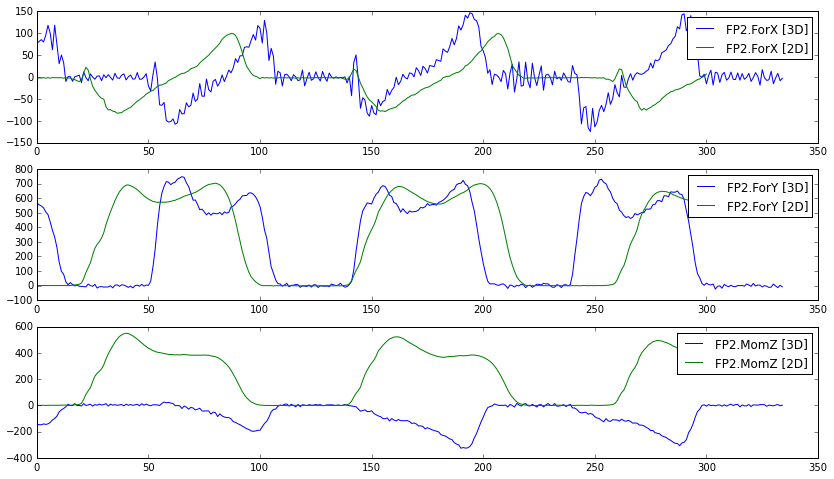

In [19]:
compare(gait_data.data, ['FP2.ForX', 'FP2.ForY', 'FP2.MomZ'],
        df, ['FP2.ForX', 'FP2.ForY', 'FP2.MomZ'])

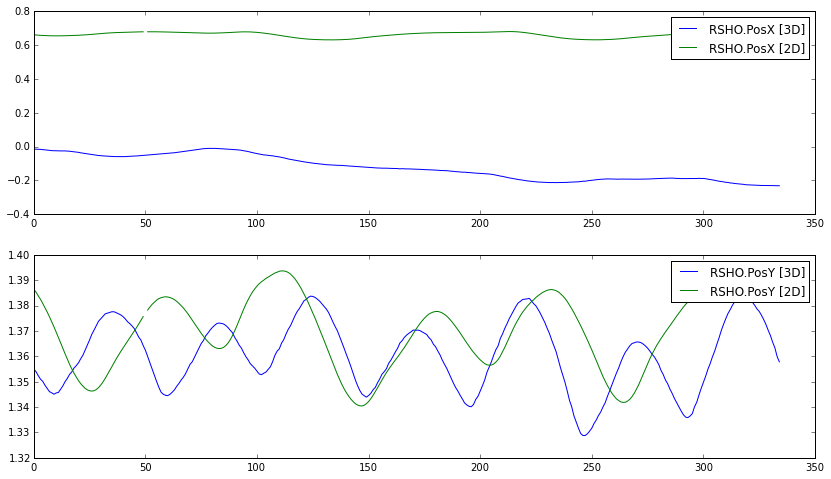

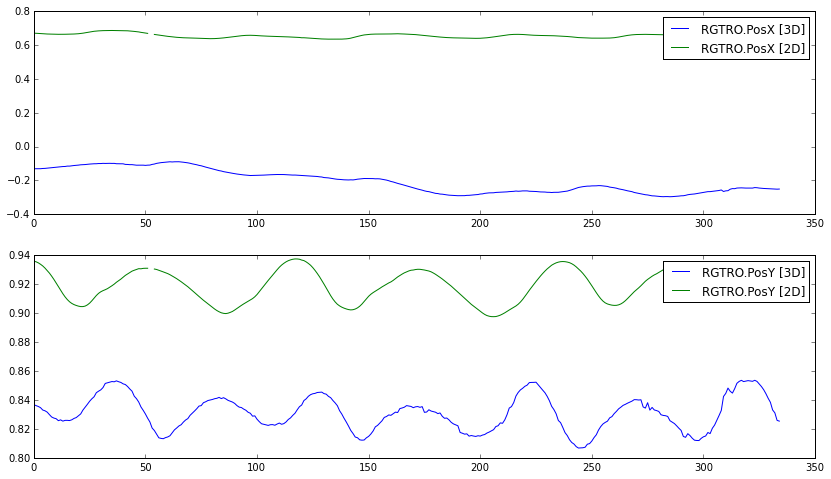

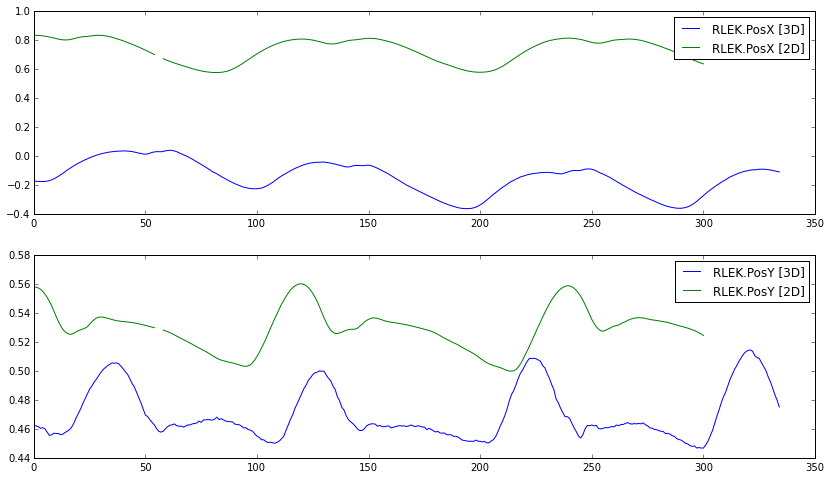

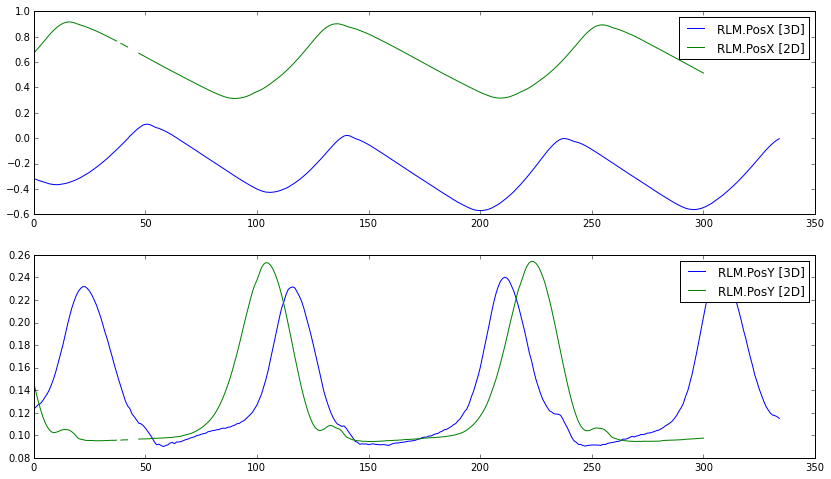

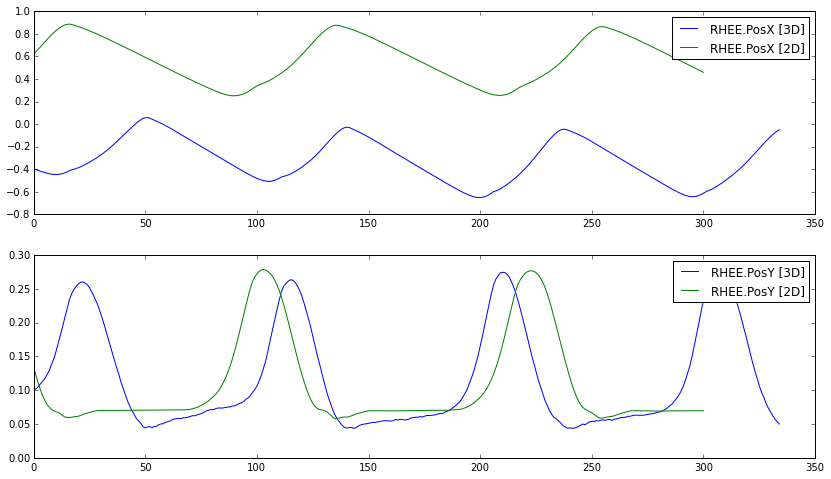

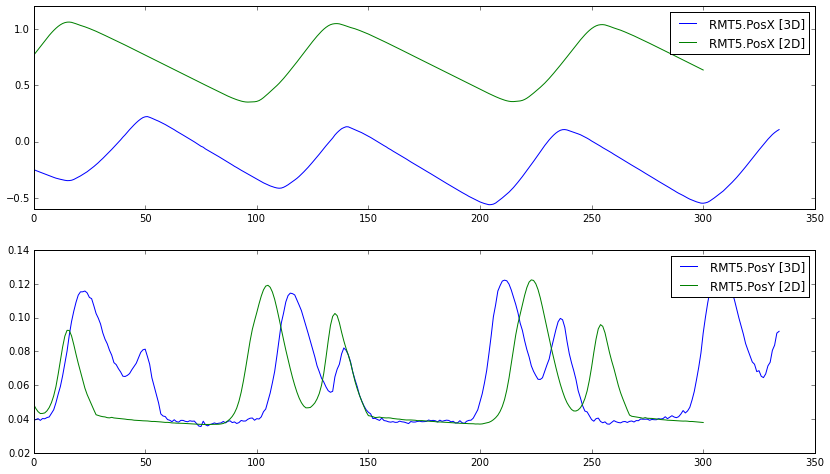

In [20]:
markers = ['RSHO', 'RGTRO', 'RLEK', 'RLM', 'RHEE', 'RMT5']

for marker in markers:
    threed = [marker + '.PosX', marker + '.PosY']
    twod = [marker + '.PosX', marker + '.PosY']
    compare(gait_data.data, threed, df, twod)

Everything seems to be fine. The differnce in the moment curves simply reflect the relative difference in the subjects fore/aft position on the treadmill.

# Compare Center of Pressure to RLM Marker

In [21]:
df['FP2.CopX'] = df['FP2.MomZ'] / df['FP2.ForY']

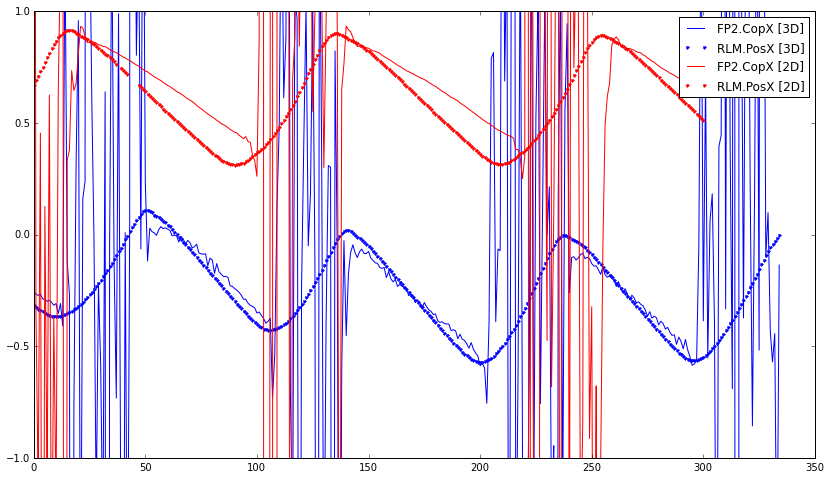

In [22]:
plt.plot(gait_data.data['FP2.CopX'].iloc[start:end], 'b-', label='FP2.CopX [3D]')
plt.plot(gait_data.data['RLM.PosX'].iloc[start:end], 'b.', label='RLM.PosX [3D]')
plt.plot(df['FP2.CopX'], 'r-', label='FP2.CopX [2D]')
plt.plot(df['RLM.PosX'], 'r.', label='RLM.PosX [2D]')
plt.ylim((-1, 1))
plt.legend()

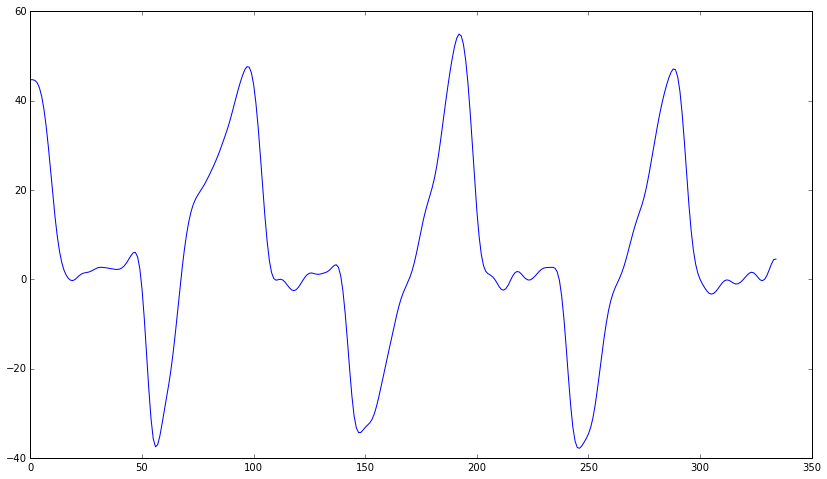

In [23]:
plt.plot(gait_data.data['Right.Ankle.PlantarFlexion.Moment'].iloc[start:end])

# Footer

In [24]:
!git rev-parse HEAD

6af0c229bb0a9edf78f8489d5f0efe02d5685a57


In [25]:
!git --git-dir=/home/moorepants/src/GaitAnalysisToolKit/.git --work-tree=/home/moorepants/src/GaitAnalysisToolKit rev-parse HEAD

9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c


In [26]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Installed version_information.py. To use it, type:
  %load_ext version_information


In [27]:
%load_ext version_information

In [28]:
%version_information numpy, scipy, pandas, matplotlib, tables, oct2py, dtk, gaitanalysis

Software,Version
Python,2.7.9 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,3.0.0
OS,Linux 3.13.0 49 generic x86_64 with debian jessie sid
numpy,1.9.2
scipy,0.15.1
pandas,0.16.0
matplotlib,1.4.2
tables,3.1.1
oct2py,3.1.0
dtk,0.4.0


In [29]:
!conda list

# packages in environment at /home/moorepants/anaconda/envs/gait-direct-id-paper:
#
backports.ssl-match-hostname 3.4.0.2                   <pip>
cairo                     1.12.18                       0  
dateutil                  2.4.1                    py27_0  
dynamicisttoolkit         0.4.0                    py27_0  
fastcache                 1.0.2                    py27_0  
fontconfig                2.11.1                        2  
freetype                  2.4.10                        0  
gaitanalysistoolkit (/home/moorepants/src/GaitAnalysisToolKit) 0.2.0.dev0                <pip>
hdf5                      1.8.14                        0  
ipython                   3.0.0                    py27_0  
ipython-notebook          3.0.0                    py27_1  
jinja2                    2.7.3                    py27_1  
jsonschema                2.4.0                    py27_0  
libpng                    1.5.13                        1  
libsodium                 0.4.5         

In [30]:
!pip freeze

backports.ssl-match-hostname==3.4.0.2
DynamicistToolKit==0.4.0
fastcache==1.0.2
-e git+git@github.com:csu-hmc/GaitAnalysisToolKit.git@9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c#egg=GaitAnalysisToolKit-origin_speedup-inverse-dynamics
ipython==3.0.0
Jinja2==2.7.3
jsonschema==2.4.0
MarkupSafe==0.23
matplotlib==1.4.2
mistune==0.5.1
nose==1.3.4
numexpr==2.3.1
numpy==1.9.2
oct2py==3.1.0
pandas==0.16.0
ptyprocess==0.4
Pygments==2.0.2
pyparsing==2.0.1
PySide==1.2.1
python-dateutil==2.4.2
pytz==2015.2
PyYAML==3.11
pyzmq==14.5.0
scipy==0.15.1
seaborn==0.5.1
six==1.9.0
snakeviz==0.3.1
sympy==0.7.6
tables==3.1.1
terminado==0.5
tornado==4.1
